In [1]:
import numpy as np
import random
import os
import networkx as nx
import matplotlib.pyplot as plt
from scipy import sparse
from tqdm import tqdm

from setup_networks import network_from_txt, network_indices, Network, network_from_edges_and_nodes
from currents import * 
from adaptation import adaptation_ode, ss_solve
from measures import steady_state_dissipation

# Define basic functions

In [13]:
def get_path_lengths(netw, source, sinks, K):
    G = nx.Graph()

    weighted_edges = np.append(netw.edgelist, 1/K[:, np.newaxis], 1)
    G.add_nodes_from(np.arange(len(netw.pos)))
    G.add_weighted_edges_from(weighted_edges, weight='K')
    
    path_length = 0
    path_weight = 0
    for s in sinks:
        path = nx.dijkstra_path(G, source, s, weight='K')
        pathweight = nx.path_weight(G, path, weight='K')
        
        path_length += len(path)
        path_weight += pathweight
        
    N_sinks = len(sinks)
    return path_length/N_sinks, path_weight/N_sinks

In [14]:
def make_ellipse_netw(netw, a, b):
    center_ind = network_indices(netw)['center']

    max_dist = np.max(np.linalg.norm(netw.pos - netw.pos[center_ind], axis=1))
    a = a/max_dist
    b = b/max_dist
    
    ellipse_dist_fn = lambda x: (x[:, 0] - x[center_ind,0])**2/a**2 + (x[:, 1]-x[center_ind,1])**2/b**2
    ellipse_dists = ellipse_dist_fn(netw.pos)
    
    inside_ellipse_ids = np.where(ellipse_dists <= 1.)[0]
    new_pos = netw.pos[inside_ellipse_ids]
    new_ids = np.arange(len(new_pos))
    
    def get_ellipse_edges(edges, ellipse_ids):
        ellipse_edges = []
        for e in edges:
            is_in_ellipse = np.any(e[0]==ellipse_ids) and np.any(e[1]==ellipse_ids)
            if is_in_ellipse:
                #find the new ids of the nodes to form edges
                e1 = new_ids[np.where(e[0]==inside_ellipse_ids)[0][0]]
                e2 = new_ids[np.where(e[1]==inside_ellipse_ids)[0][0]]
                ellipse_edges += [[e1, e2]]        
        return np.array(ellipse_edges)

    new_edges = get_ellipse_edges(netw.edgelist, inside_ellipse_ids)
    
    return network_from_edges_and_nodes(new_edges, new_pos)

In [15]:
def remove_edges(netw, K, cutoff=1e-4):
    real_edge_ids = np.where(K > cutoff)[0]
    edges = netw.edgelist[real_edge_ids]
    return network_from_edges_and_nodes(edges, netw.pos), K[real_edge_ids]

In [16]:
def get_sinks(N_sinks, netw):
    inds = network_indices(netw)
    edge_node = inds['left']
    maxdist = np.max(np.linalg.norm(netw.pos - netw.pos[edge_node], axis=1))
    spacing = maxdist / np.sqrt(N_sinks)
    
    def get_next_point(curr_pos, spacing, node_positions, all_points_in_xtal):
        dists = np.abs(np.linalg.norm(curr_pos - node_positions, axis=1) - spacing)
        sorted_points = np.argsort(dists)

        for i in sorted_points:
            if len(all_points_in_xtal)==0:
                return i#, list(node_positions[i])

            already_in_list = np.min(np.linalg.norm(node_positions[i] - node_positions[np.array(all_points_in_xtal)], axis=1)) < spacing
    
            if not already_in_list:
                return i#, list(node_positions[i])
        return None#, None
    
    sink_inds = []
    curr_ind = edge_node
    for i in range(N_sinks):
        sink_ID = get_next_point(netw.pos[curr_ind], spacing, netw.pos, sink_inds)
        if sink_ID is None:
            break;
        sink_inds += [sink_ID]
        curr_ind = sink_ID
        
    return np.array(sink_inds)

In [42]:
num_sinks = np.random.randint(30, 40)
sink_nodes = get_sinks(num_sinks, netw)

In [43]:
sink_nodes

array([432, 360, 342, 126, 305, 121, 278, 290, 346, 107, 366,  22, 395,
       292, 284,  39,  83, 433, 151, 112,  65, 158, 187, 160])

In [31]:
'''
Computes matrices where the ijth index is the result for kappas[i] and rhos[j].

We compute matrices for the following quantities:
    - energy of the network
    - average shortest path length from source to sink
    - average weight of the shortest path length from source to sink, where the weight = 1/K
    
Inputs:
    - netw: original network
    - kappas: array of kappas to test
    - rhos: array of rhos to test
    - source: position of the insertion point, must be set to 'center' or 'left'
    - a, b: aspect ratio parameters (if a =/= b, then the placenta will be elliptical)
    - N_replicates: the number of replicates to average over per element in the matrix
    - save_mats: boolean that determines whether to save the matrices to a numpy array
'''

def get_phase_diagram_matrices(netw, kappas, rhos, source='center', a=1, b=1, N_replicates=10, save_mats=True):

    if a != b:
        netw = make_ellipse_netw(netw, a, b)
        
    inds = network_indices(netw)
    source_ind = inds[source]
    gamma = 0.5
    beta = 1.0 / (1 + gamma)
    
    N_kappas = len(kappas)
    N_rhos = len(rhos)
    energies = np.zeros((N_kappas, N_rhos))
    shortest_path_lengths = np.zeros((N_kappas, N_rhos))
    shortest_path_weights = np.zeros((N_kappas, N_rhos))
    for k in tqdm(range(len(kappas))):
        for p in range(len(rhos)):
            kappa = kappas[k]
            rho = rhos[p]

            E = 0
            pathlengths = 0
            pathweights = 0
            for _ in range(N_replicates):
                K0 = -np.log10(np.random.rand(netw.N_e))

                # To add stochasticity, vary the number of sinks in the range that matches experiments
                num_sinks = np.random.randint(30, 40)
                sink_nodes = get_sinks(num_sinks, netw)

                currents = lambda K, netw: static_currents(K, netw, source_index=source_ind, sink_nodes=sink_nodes)
                K, converged = ss_solve(lambda K, t: adaptation_ode(K, t, netw, currents, kappa, beta, rho), K0, Δt=1.0)
                if not converged:
                    print(f"Did not converge at k={kappa}, p={rho}")

                # clip extraneous edges
                new_netw, new_K = netw, K
                #new_netw, new_K = remove_edges(netw, K) #NOTE: this causes issues with the shortest path calc

                pathlen, pathweight = get_path_lengths(new_netw, source_ind, sink_nodes, new_K)
                pathlengths += pathlen
                pathweights += pathweight

                # To compute energy, we have to use the unclipped network 
                # (with extraneous vessels that have tiny conductances)
                I = np.sqrt(currents(K, netw))
                R = netw.lengths/K
                E += np.mean(I*R)
                #E += steady_state_dissipation(K, netw, source_index=i)

            energies[k, p] = E/N_replicates
            shortest_path_lengths[k, p] = pathlengths/N_replicates
            shortest_path_weights[k, p] = pathweights/N_replicates

    if save_mats:
        np.save(f'../output/energies_a1_b1_source{source}.txt', energies, allow_pickle=False)
        np.save(f'../output/pathlengths_a1_b1_source{source}.txt', shortest_path_lengths, allow_pickle=False)
        np.save(f'../output/pathweights_a1_b1_source{source}.txt', shortest_path_weights, allow_pickle=False)
    
    return energies, shortest_path_lengths, shortest_path_weights




def plot_phase_diagrams(kappas, rhos, energies, shortest_path_lengths, shortest_path_weights, source='center', a=1, b=1):
    N_kappas = len(kappas)
    N_rhos = len(rhos)
    
    fig, axs = plt.subplots(1, 3, figsize=(35, 10))

    im0 = axs[0].imshow(energies, origin='lower')
    axs[0].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
    axs[0].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
    axs[0].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=25);
    axs[0].set_yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=25);
    axs[0].set_title('Voltage', fontsize=30)
    clb = fig.colorbar(im0, ax=axs[0]);
    clb.ax.tick_params(labelsize=20) 
    # clb.ax.set_title('Voltage',fontsize=20)


    im1 = axs[1].imshow(shortest_path_lengths, origin='lower')
    axs[1].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
    axs[1].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
    axs[1].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=25);
    axs[1].set_yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=25);
    clb1 = fig.colorbar(im1, ax=axs[1]);
    clb1.ax.tick_params(labelsize=20) 
    # clb1.ax.set_title('Path Length', fontsize=20)
    axs[1].set_title('Shortest Path Length', fontsize=30)



    im2 = axs[2].imshow(shortest_path_weights, origin='lower')
    axs[2].set_xlabel(r'$\log_{10}(1 + \rho)$', fontsize=30);
    axs[2].set_ylabel(r'$\log_{10}(\kappa)$', fontsize=30);
    axs[2].set_xticks(ticks=np.arange(N_rhos), labels=np.round(np.log10(1 + rhos), 2), fontsize=25);
    axs[2].set_yticks(ticks=np.arange(N_kappas), labels=np.log10(kappas), fontsize=25);

    clb2 = fig.colorbar(im2, ax=axs[2]);
    # clb2.ax.set_title('Path Length', fontsize=20)
    clb2.ax.tick_params(labelsize=20) 
    axs[2].set_title('Shortest Path Weight', fontsize=30)

    fig.suptitle('Source: ' + source + ', Aspect Ratio: {}/{}'.format(a, b), fontsize=45)
    

# Make phase diagrams

In [32]:
netw = network_from_txt("../lattices/paper_edges.txt", "../lattices/paper_nodes.txt")

N_kappas = 5
N_rhos = 5
N_sinks = 35 #30-40 is the normal range per Andrew Melbourne
N_replicates=10


kappas = np.logspace(-3, 0, N_kappas)
rhos = np.logspace(0, 2, N_rhos)

gamma = 0.5
beta = 1.0 / (1 + gamma)

## Circular, varied insertion point

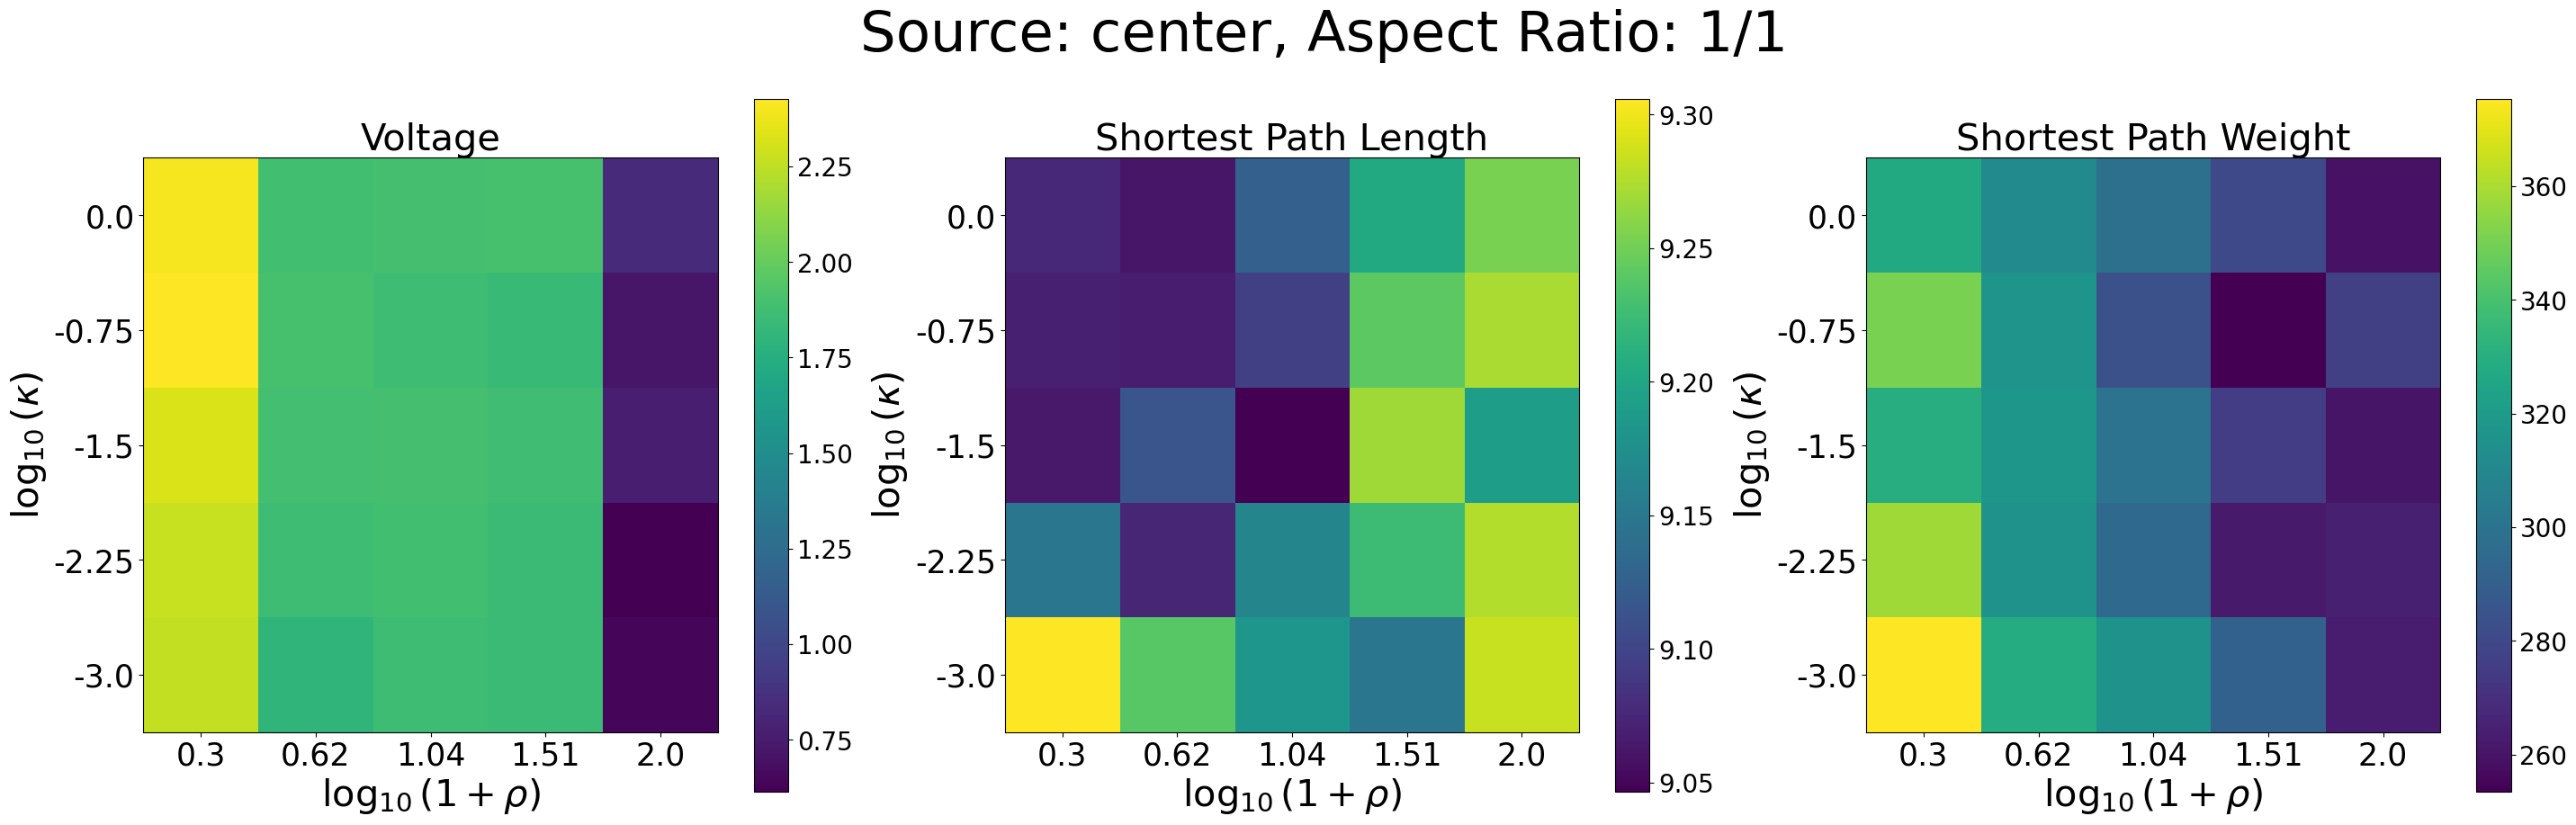

In [33]:
source = 'center'
a = 1
b = 1

energies, shortest_path_lengths, shortest_path_weights = get_phase_diagram_matrices(netw, kappas, rhos, source=source, a=a, b=b, N_replicates=10, save_mats=True) 
plot_phase_diagrams(kappas, rhos, energies, shortest_path_lengths, shortest_path_weights, source=source, a=a, b=b)

In [45]:
kappas[0]
#k=1.0
#first screen shot: 1.0, 1.0 = (kappa, rho)
#second screen shot: 1.0, 100.0 = (kappa, rho)
#third screen shot: 0.001, 100.0 = (kappa, rho)
#fourth screen shot: 0.001, 1.0 = (kappa, rho)

#TRY: metric that's total length / sqrt(area), length = total length of nonzero edges

0.001

In [ ]:
'''
Twin-twin transfusion syndrome: same placenta, vasculature for both get mixed up and one baby gets more blood

can we model this? two sources with different pressures. maybe for some regimes of kappa and 
rho you get cross talk/vasculature mixing (not just two separable networks for the two sources)
'''


100%|████████████████████████████████████████████| 5/5 [16:02<00:00, 192.41s/it]


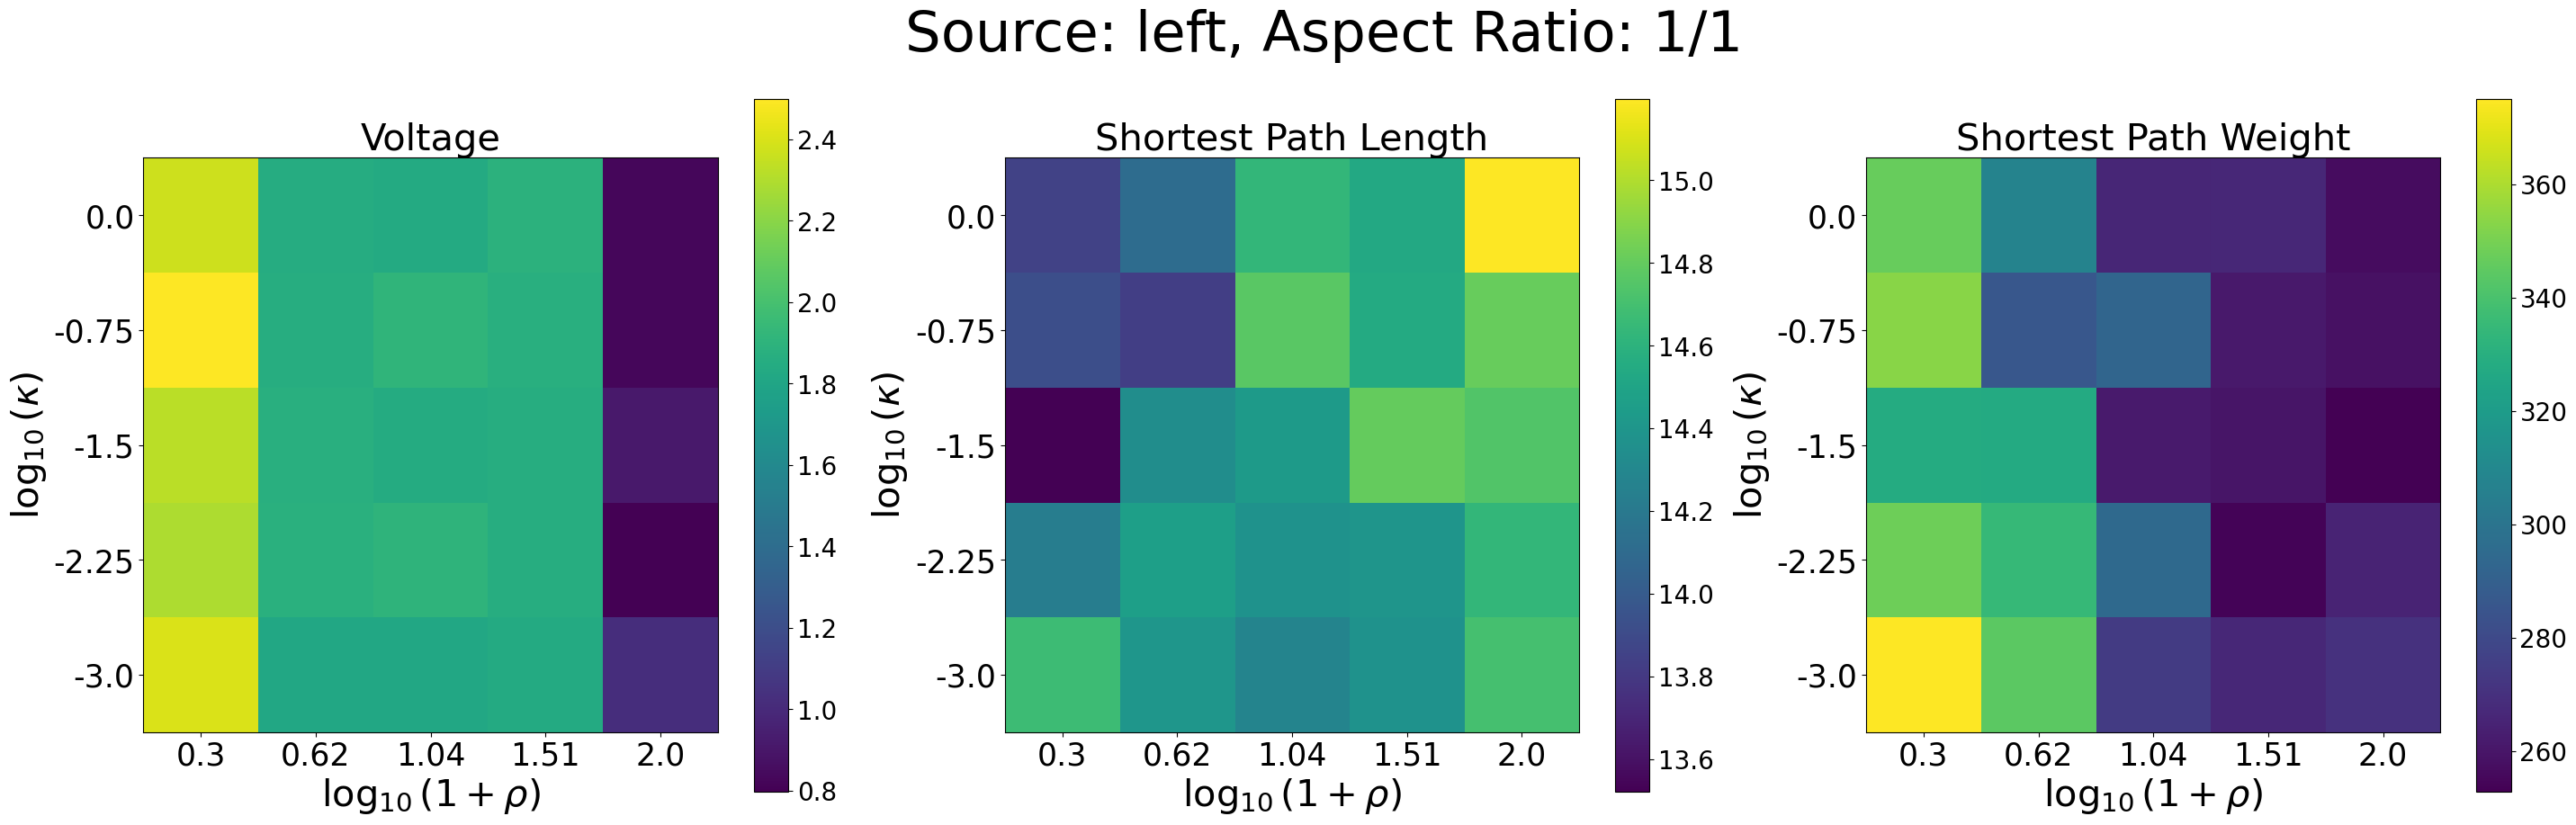

In [36]:
source = 'left'
a = 1
b = 1

energies, shortest_path_lengths, shortest_path_weights = get_phase_diagram_matrices(netw, kappas, rhos, source=source, a=a, b=b, N_replicates=10, save_mats=True) 
plot_phase_diagrams(kappas, rhos, energies, shortest_path_lengths, shortest_path_weights, source=source, a=a, b=b)

## Elliptical, varied insertion point

(0.5937104580000002, 2.946577722, -0.6310550358749998, 0.5572817291249998)

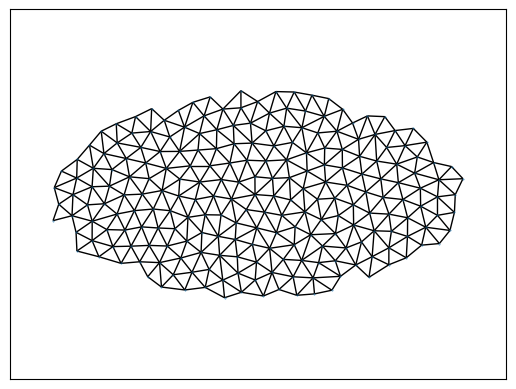

In [34]:
# define aspect ratio of ellipse by varying a, b
a = 1.
b = 0.5
netw = network_from_txt("../lattices/paper_edges.txt", "../lattices/paper_nodes.txt")
ellipse_netw = make_ellipse_netw(netw, a, b)

G = nx.Graph()
node_pos = ellipse_netw.pos
nodes = np.arange(len(node_pos))
node_dict = {}
for n in nodes:
    node_dict[n] = node_pos[n]

edges = ellipse_netw.edgelist
G.add_nodes_from(nodes)
G.add_edges_from(edges)


nx.draw_networkx(G, pos=node_dict, width=1., with_labels=False, node_size=0.1)
plt.axis('equal')


100%|█████████████████████████████████████████████| 5/5 [03:37<00:00, 43.51s/it]


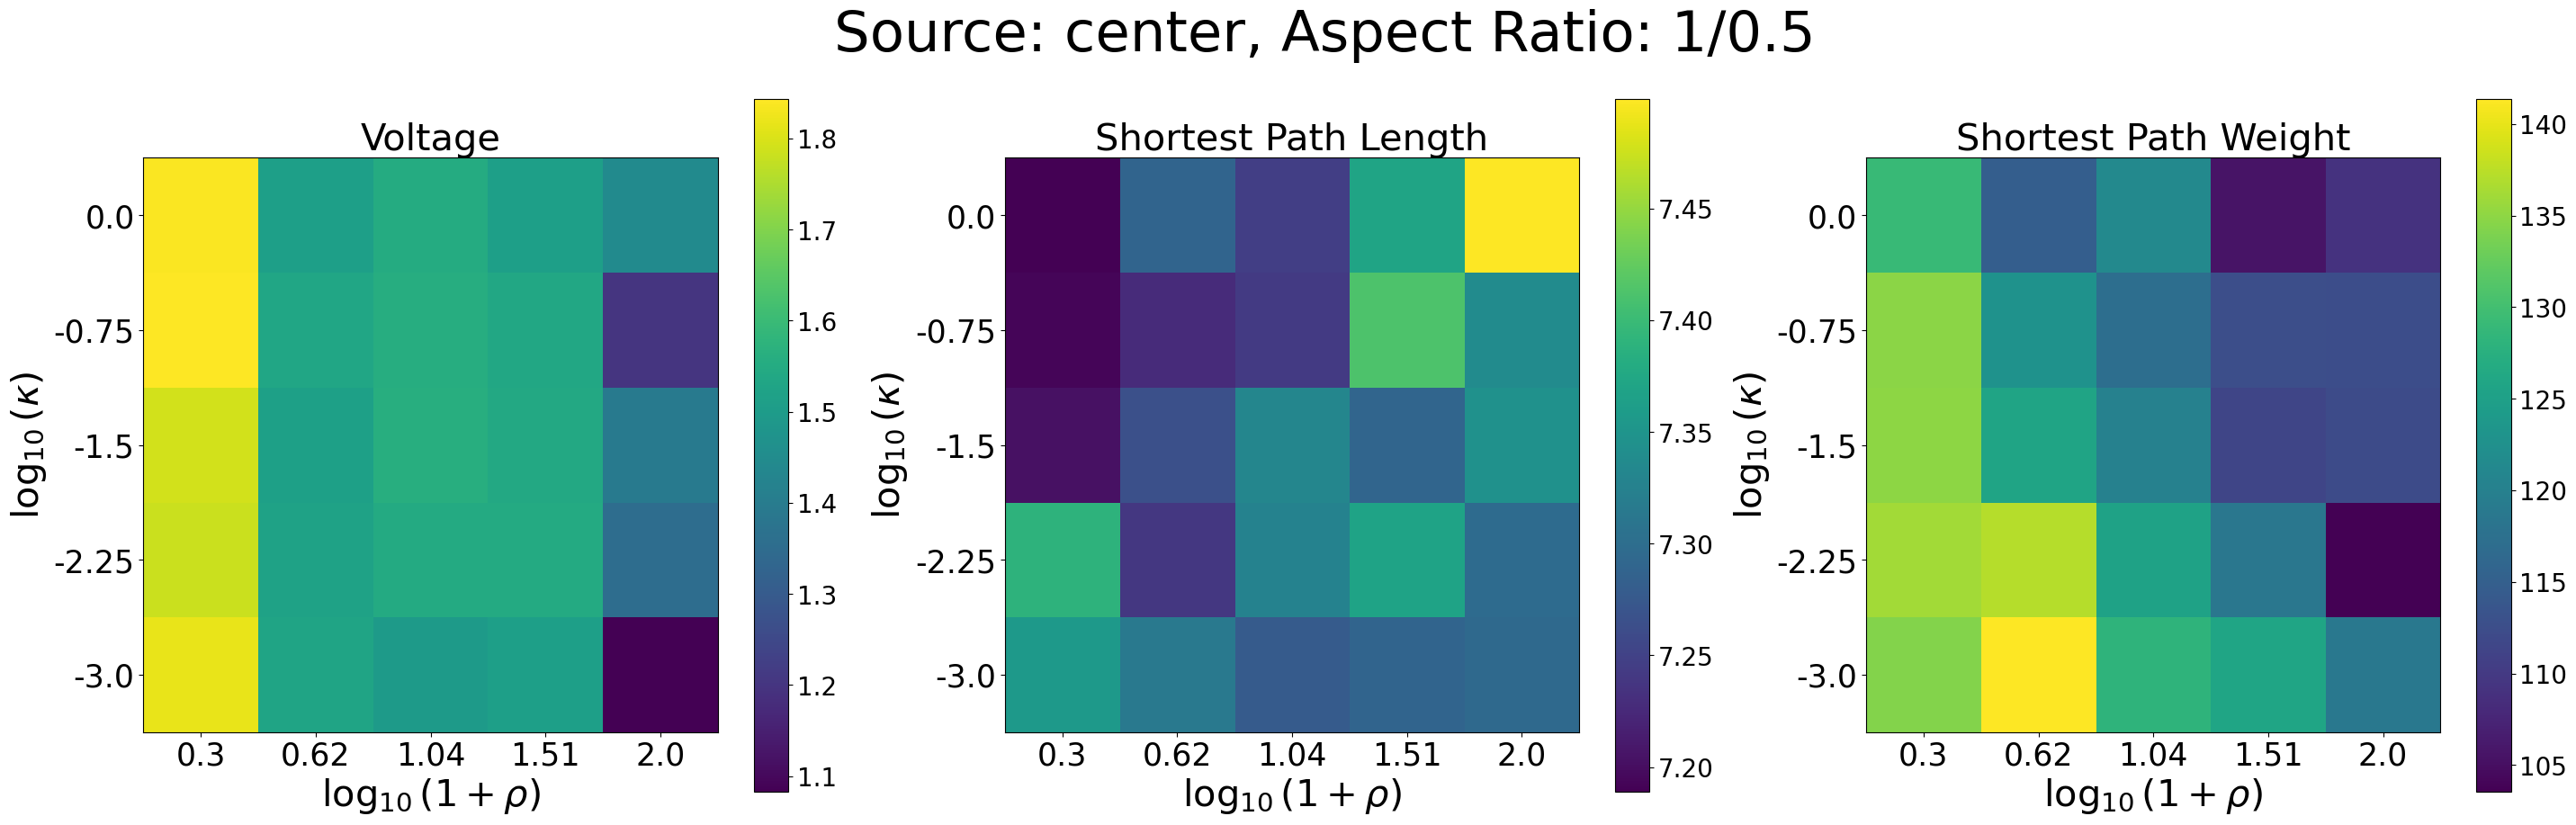

In [35]:
source = 'center'
a = 1
b = 0.5

energies, shortest_path_lengths, shortest_path_weights = get_phase_diagram_matrices(netw, kappas, rhos, source=source, a=a, b=b, N_replicates=10, save_mats=True) 
plot_phase_diagrams(kappas, rhos, energies, shortest_path_lengths, shortest_path_weights, source=source, a=a, b=b)

100%|█████████████████████████████████████████████| 5/5 [03:59<00:00, 47.87s/it]


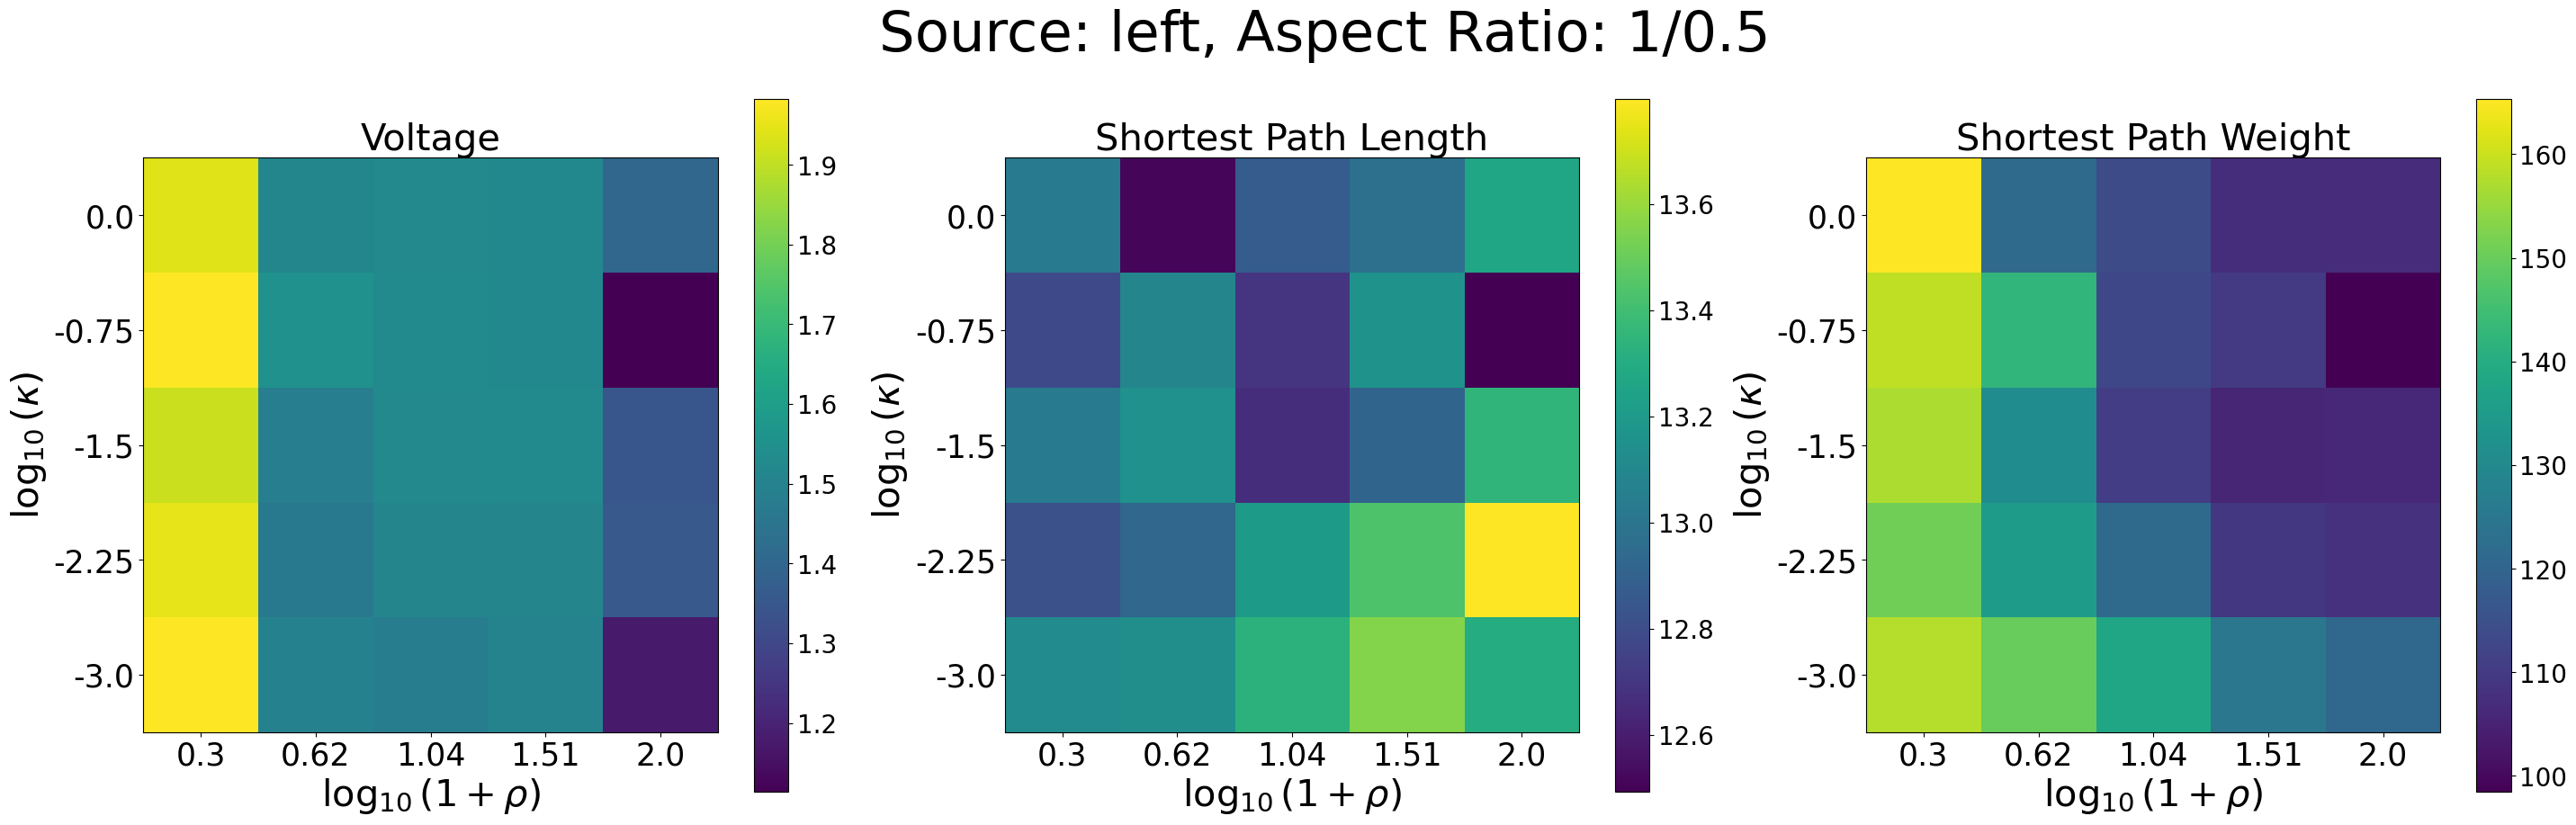

In [37]:
source = 'left'
a = 1
b = 0.5

energies, shortest_path_lengths, shortest_path_weights = get_phase_diagram_matrices(netw, kappas, rhos, source=source, a=a, b=b, N_replicates=10, save_mats=True) 
plot_phase_diagrams(kappas, rhos, energies, shortest_path_lengths, shortest_path_weights, source=source, a=a, b=b)

- dissipation is sum over pressures only at sources and sinks
- count # edges